# Accelerate your code with cuda

## Writing CUDA Kernels in Python
- Kernel Function Implementation
    The kernel function needs to be preceded by the **@cuda.jit** decorator:
```Python
    @cuda.jit
    def add_kernel(x, y, out):
```
- Kernel Function Invocation
    Execution settings need to be specified:
    **add_kernel[blocks_per_grid, threads_per_block](x, y, out)**  
    The `blocks_per_grid` represents the number of blocks in the x, y, and z dimensions of the grid.  
    The `threads_per_block` represents the number of threads in the x, y, and z dimensions of each block.

Below is an example of vector addition using CUDA in Python:

In [1]:
from numba import cuda

@cuda.jit
def add_kernel(x, y, out):
    block_size = cuda.blockDim.x  
    grid_size = cuda.gridDim.x    

    # tx = cuda.threadIdx.x 
    # ty = cuda.blockIdx.x  
    # start = tx + ty * block_size
    
    start = cuda.grid(1)
    stride = block_size * grid_size
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

In [2]:
import numpy as np

n = 100000
x = np.arange(n).astype(np.float32) / 1000.0
y = 2 * x

d_x = cuda.to_device(x)
d_y = cuda.to_device(y)
d_out = cuda.device_array(n, dtype=np.float32)

threads_per_block = 256
blocks_per_grid = 30

add_kernel[blocks_per_grid, threads_per_block](d_x, d_y, d_out)

cuda.synchronize()
out = d_out.copy_to_host()
print(out[:20])

[0.    0.003 0.006 0.009 0.012 0.015 0.018 0.021 0.024 0.027 0.03  0.033
 0.036 0.039 0.042 0.045 0.048 0.051 0.054 0.057]


/usr/local/lib/python3.11/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 30 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


## Image Format Overview

### Image Channels
- **RGB (Red-Green-Blue)**: A common color model where each pixel is represented by three values corresponding to red, green, and blue color channels. Each channel represents the intensity of that color component at a particular pixel. Usually ranges from `0 to 255`(8 bits unsigned integer) or `0 to 1`(floating point) for each channel.
- **Grayscale**: A grayscale image consists of only one channel where each pixel represents intensity or brightness. It ranges from black (low intensity) to white (high intensity), with various shades of gray in between.
- **HSV (Hue-Saturation-Value)**: Not discussed in this lecture, but another color model that represents colors in terms of their shade, saturation, and brightness.

### Image Dimensions
- **Height (H)**: The vertical size of the image, measured in pixels.
- **Width (W)**: The horizontal size of the image, measured in pixels.
- **Channels (C)**: The number of color channels in the image. For RGB images, this is 3 (one each for red, green, and blue). For grayscale images, this is 1.

### Image Storage Formats

- **HWC (Height-Width-Channel)**
    - In this format, the dimensions of an image are stored in the order of height, width, and channel. 
    - For example, an RGB image with a height of 256 pixels, width of 256 pixels, and 3 color channels would be stored as a 3D array with the shape (256, 256, 3). 
    - The third dimension represents the color channels.

- **CHW (Channel-Height-Width)**
    - This format stores the image dimensions in the order of channel, height, and width. 
    - For the same RGB image with a height of 256 pixels, width of 256 pixels, and 3 color channels, the shape would be (3, 256, 256). 
    - The first dimension represents the color channels, followed by height and width.

OpenCV uses the HWC format, with ranges from 0 to 255 for each channel. PyTorch uses the CHW format, with ranges from 0 to 1 for each channel.

## Exercise: RGB to Grayscale Conversion

### Some background knowledge

#### What is a Grayscale Image?

A grayscale image is a type of image where each pixel represents only the intensity of light, ranging from black (low intensity) to white (high intensity), with various shades of gray in between. Unlike RGB images that use three channels (red, green, blue) to represent colors, grayscale images use only one channel to represent intensity.

#### Why Convert RGB to Grayscale?

Grayscale images are simpler and require less computational resources to process compared to RGB images. Converting an image to grayscale is useful in many applications such as image processing, computer vision, and image analysis where color information is not essential.

#### Grayscale Conversion Formula

To convert an RGB image to grayscale, we use a weighted average of the red, green, and blue components. The formula is:

$$
\text{Gray} = 0.2989 \times R + 0.5870 \times G + 0.1140 \times B
$$

where:
- **R** is the red component,
- **G** is the green component,
- **B** is the blue component.

#### Why These Coefficients?

The coefficients \(0.2989\), \(0.5870\), and \(0.1140\) are derived from the luminance perception of the human eye.  
The human eye is more sensitive to green light and less sensitive to blue light. Therefore, the green component has the highest weight, while the blue component has the lowest weight.  
These weights are used to more accurately represent the perceived intensity of the colors in a grayscale image.


You need to complete the `rgb2gray_kernel` funtction below.

In [6]:
import numpy as np
import cv2
from numba import cuda

# Function to convert RGB image to grayscale using CPU
def rgb2gray(img):
    c, h, w = img.shape
    n = h * w
    img = img.flatten()
    res = np.zeros(n, dtype=np.float32)
    
    for i in range(n): 
        res[i] = 0.2989*img[i] + 0.5870*img[i+n] + 0.1140*img[i+2*n]
    
    return res.reshape(h, w)

# Kernel function for RGB to grayscale conversion
@cuda.jit
def rgb2gray_kernel(rgb, gray):
    c, h, w = rgb.shape
    x, y = cuda.grid(2)
    
    ##### YOUR CODE STARTS HERE #####
    
    ##### END OF YOUR CODE #####

# Function to convert RGB image to grayscale using GPU
def rgb2gray_cuda(rgb):
    rgb = np.ascontiguousarray(rgb)
    c, h, w = rgb.shape
    
    d_rgb = cuda.to_device(rgb)
    d_gray = cuda.device_array((h, w), dtype=np.float32)

    threads_per_block = (16, 16)
    blocks_per_grid_x = (w + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (h + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    rgb2gray_kernel[blocks_per_grid, threads_per_block](d_rgb, d_gray)
    
    cuda.synchronize()
    return d_gray.copy_to_host()

In [7]:
# Load image using OpenCV
image = cv2.imread("images/cat.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image from BGR to RGB
image = image.transpose(2, 0, 1)  # Convert from (H, W, C) to (C, H, W) format

In [8]:
import time
from functools import wraps

# Timer decorator to measure the execution time of functions
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function '{func.__name__}' took {end_time - start_time:.4f} seconds to execute.")
        return result
    return wrapper

@timeit
def test_rgb2gray_cuda(image):
    return rgb2gray_cuda(image)

@timeit
def test_rgb2gray(image):
    return rgb2gray(image)

result_cpu = test_rgb2gray(image)
result_gpu = test_rgb2gray_cuda(image)

# Ensure that the CPU and GPU implementations produce the same result
assert np.all(result_cpu == result_gpu)

Function 'test_rgb2gray' took 15.4610 seconds to execute.
Function 'test_rgb2gray_cuda' took 0.0798 seconds to execute.


In [9]:
# Convert the result image to uint8 type
result_cpu = result_cpu.clip(0, 255).astype(np.uint8)
result_gpu = result_gpu.clip(0, 255).astype(np.uint8)

# Save the grayscale image
cv2.imwrite('grey_cat.jpg', result_gpu)

True

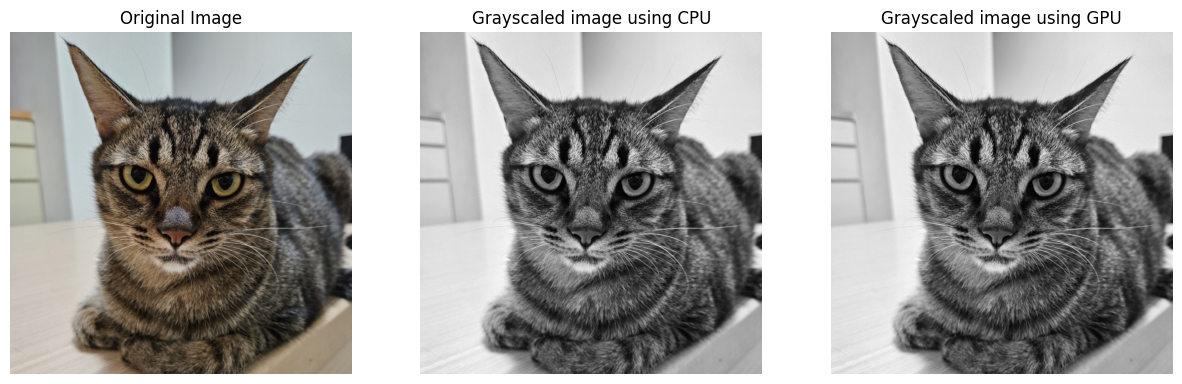

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image.transpose(1, 2, 0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(result_cpu, cmap='gray')
plt.title('Grayscaled image using CPU')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(result_gpu, cmap='gray')
plt.title('Grayscaled image using GPU')
plt.axis('off');

## Exercise: Image Convolution with Gaussian Kernel

In fact, the exercise is to implement correlation instead of convolution(but will have the same result).  
The convolution operation is a type of correlation operation (with the kernel flipped).  
In this case, you can think of that correlation is doing the same thing as convolution. 

The correlation operation is defined as follows:  
Let the image be denoted by `I` and the kernel (or filter) by `K`.  
The result of the correlation operation at position `(x,y)` in the output image `R` can be written as:

$$
R(x, y) = \sum_{k=0}^{H-1} \sum_{l=0}^{W-1} K(l, k) \cdot I(x + l - \frac{W}{2}, y + k - \frac{H}{2})
$$

You need to complete the `conv_kernelfc` funtction below.

In [ ]:
# Kernel function for convolution
@cuda.jit
def conv_kernelfc(image, conv_kernel, result):
    x, y = cuda.grid(2) 
    channels, image_rows, image_cols = image.shape
    
    if (x < image_cols) and (y < image_rows):  # Check bounds in image width (x) and height (y)
        # Calculate result[c, y, x] for c = 0, 1, 2
        # and store the result here
        
        delta_rows = conv_kernel.shape[0] // 2 
        delta_cols = conv_kernel.shape[1] // 2
        
        for c in range(channels):
            result[c, y, x] = 0  # Note: y corresponds to height, x to width
            
        ##### YOUR CODE STARTS HERE ####

        ##### END OF YOUR CODE #####
                        
image = cv2.imread("images/Lenna.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image from BGR to RGB
image = image.transpose(2, 0, 1)  # Convert from (H, W, C) to (C, H, W) format

# gaussian kernel
kernel = np.array([[1 , 4 , 7 , 4 , 1],
                   [4 , 16, 26, 16, 4],
                   [7 , 26, 41, 26, 7],
                   [4 , 16, 26, 16, 4],
                   [1 , 4 , 7 , 4 , 1]], dtype=np.float32)
kernel /= kernel.sum()

pad_size = (kernel.shape[0] // 2, kernel.shape[1] // 2)
pad_width = ((0, 0), pad_size, pad_size)
padded_image = np.pad(image, pad_width, 'edge')
padded_image = np.ascontiguousarray(padded_image)

d_image = cuda.to_device(padded_image)
d_kernel = cuda.to_device(kernel)
d_result = cuda.to_device(padded_image)

c, h, w = image.shape
threads_per_block = (16, 16)
blocks_per_grid_x = (w + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (h + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

conv_kernelfc[blocks_per_grid, threads_per_block](d_image, d_kernel, d_result)

cuda.synchronize()

result = d_result.copy_to_host()
result = result[:, pad_size[0]:-pad_size[0], pad_size[1]:-pad_size[1]]

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.transpose(1, 2, 0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result.transpose(1, 2, 0))
plt.title('Blurred Image')
plt.axis('off');